In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,classification

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re


In [4]:
# def get_reddit_posts(subreddit, pages):
# subreddit = 'AskHistory'
# pages = 40
# url = "https://www.reddit.com/r/" + subreddit + ".json"
# headers = {'User-agent':'Time Bandit'}
# after = None
# posts = []
# for j in range(pages):
#     if after==None:
#         params = {}
#     else:
#         params = {'after':after}
#     print(j)  # just to keep track of progress while it is running
#     res = requests.get(url,params=params, headers=headers)
#     if res.status_code==200:
#         the_json = res.json()
#         for i in range(len(the_json['data']['children'])):
#             posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
#                               'name':the_json['data']['children'][i]['data']['name'],
#                               'title':the_json['data']['children'][i]['data']['title'],
#                           'text':the_json['data']['children'][i]['data']['selftext'],
#                           'url':the_json['data']['children'][i]['data']['url'],
#                              'is_self': the_json['data']['children'][i]['data']['is_self']})
#         after = the_json['data']['after']
#     else:
#         print(res.status_code)
#         break
#     time.sleep(1)
# df = pd.DataFrame(posts)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [5]:
# df.to_pickle('AskHistory_Apr4.pkl')

In [3]:
df_history = pd.read_pickle('./AskHistory_Apr4.pkl')

In [4]:
df_science = pd.read_pickle('./science.pkl')

In [5]:
df = pd.concat([df_history, df_science])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

askscience    1001
AskHistory     997
Name: subreddit, dtype: int64

In [6]:
df['is_self'].value_counts()

True    1998
Name: is_self, dtype: int64

In [7]:
# remove cases with blank text
# df = df[df['text']!='']

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(1973, 6)

In [90]:
# calculate baseline
df.subreddit.value_counts(normalize=True)

askscience    0.507349
AskHistory    0.492651
Name: subreddit, dtype: float64

In [10]:
df['text'] = df['text'] +' '+ df['title']

In [11]:
# Data Cleaning
# Binarize label column
df['science'] = df['subreddit'].apply(lambda x: 1 if x == 'askscience' else 0)

# get rid of \n,  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [12]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

In [13]:
X = df['text']  # X will be turned into a matrix
y = df['science']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [19]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=.8)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 1.000
Test score: 0.929


In [20]:
# set up X, y for Naive Bayes and SVC Models
X = df[['text']]  # X is a pd Dataframe
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [40]:
cvec = CountVectorizer(stop_words=None,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.01)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.993
Test data accuracy: 0.943


In [33]:
cvec = CountVectorizer(stop_words=None,max_features=4000,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=1)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.984
Test data accuracy: 0.968


In [81]:
# print confusion matrix
y_pred = nb.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,231,18
actual pos,11,240


In [15]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

import re
# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# list false positives - predicted Science but actually History
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
X_test[mask]

,text,y_test,y_pred,word_count
240,Hello first post here. I have an artillery cas...,0,1,54
282,"Now, while I'm aware that they're stylistic an...",0,1,134
474,I am doing research for a test and cannot fin...,0,1,35
648,"Sorry if this isn't allowed as a question, but...",0,1,106
866,I was speaking in Spanish with a coworker toda...,0,1,70
317,Something I got from a short reading. 50 acre...,0,1,85


In [40]:
X_test.text.loc[648]

"Sorry if this isn't allowed as a question, but I'm not sure where else to ask...  A lot of biographic novels or local histories are written with insights from those who lived through those times by their letters/diaries. As we stop keeping those sorts of things, how will historians handle losing that source of primary information. It's not like Google or Facebook will let people into their servers (assuming they store the information that long).  Is moving to the digital age causing an issue for documentation? How will future historians deal with the decrease in primary source material such as diaries/letters?"

In [26]:
X_test['word_count'].mean()

61.558

In [29]:
X_test['word_count'][mask].mean()

80.66666666666667

In [30]:
# list false negatives
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
X_test[mask]

,text,y_test,y_pred,word_count
1227,Noticed a news report today about a state of e...,1,0,130
1114,And do people in the different types of coma h...,1,0,67
1065,Just a shower thought I had when I was review...,1,0,81
1830,Were dinosaurs warm blooded or cold blooded?,1,0,7
1133,How did scientists first determine what was a...,1,0,27
1325,"A geologist was quoted by the BBC as saying ""...",1,0,52
1618,How does a Portuguese Man O' War reproduce if...,1,0,16
1019,Did the atomic bombs dropped on Hiroshima and...,1,0,27
1925,"Argentavis Magnificens is, currently, the worl...",1,0,62
1759,"Herodotus reports (I,80) that Cyrus used camel...",1,0,43


In [52]:
X_test.text.loc[1838]

' Can you contract multiple strains of the flu at one time?'

In [31]:
X_test['word_count'][mask].mean()

57.76470588235294

In [89]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.990
Test data accuracy: 0.968


In [51]:
tvec = TfidfVectorizer(stop_words=None,max_features=None, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.02)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.991
Test data accuracy: 0.951


In [70]:
# SVM model
cvec = CountVectorizer(stop_words=None,max_features=800, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
# svc = svm.SVC(kernel='poly', C = 1.8, gamma = .05) 
svc = svm.SVC(kernel='rbf', C = 5, gamma = .005)  

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.966
Test data accuracy: 0.909


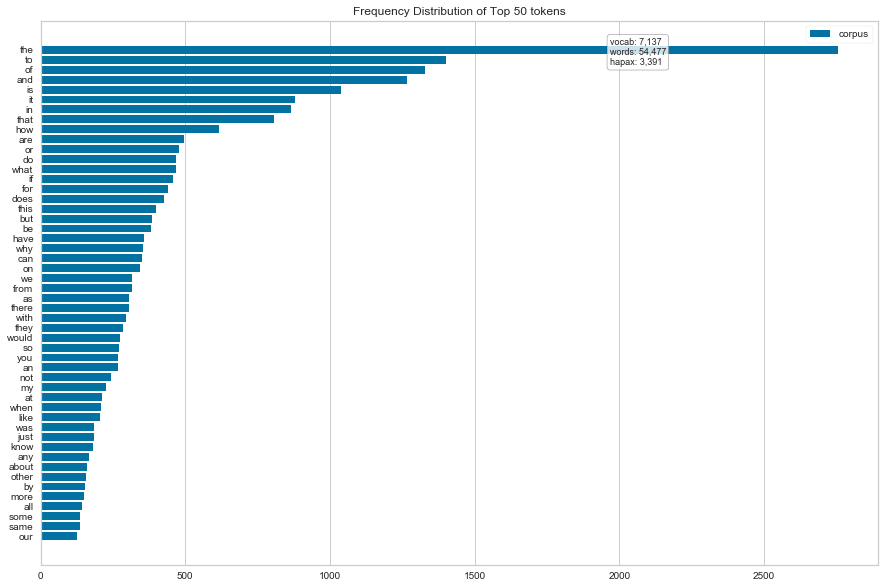

In [88]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
mask       = (df['science'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,)
visualizer.fit(docs)
visualizer.poof()

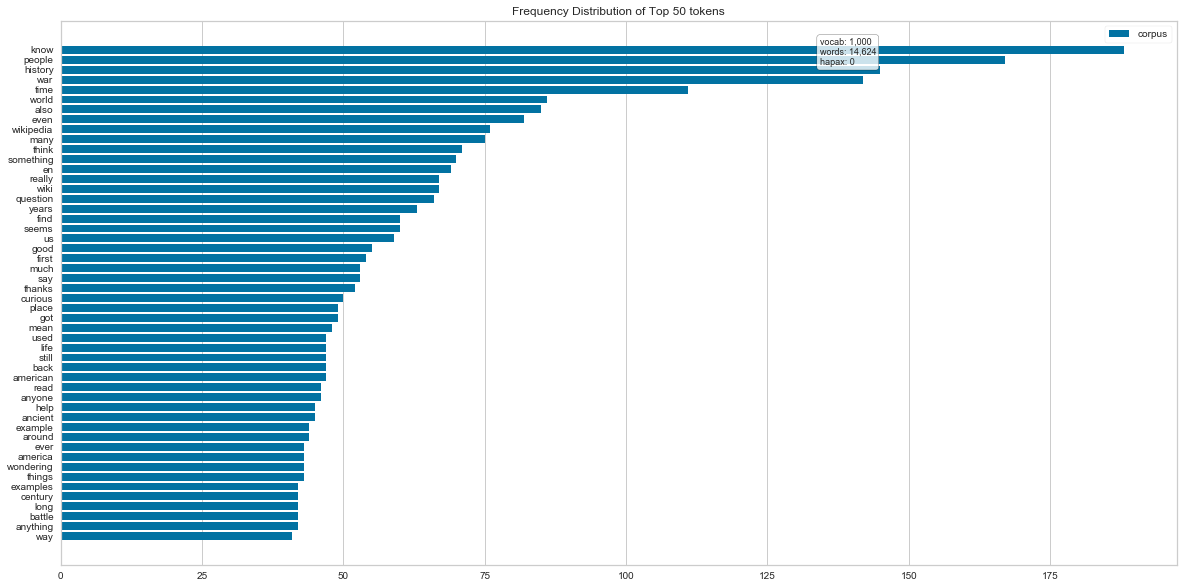

<Figure size 1080x720 with 0 Axes>

In [104]:
mask       = (df['science'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
visualizer = FreqDistVisualizer(features=features,n=50,kwargs={'color':'r'})
visualizer.fit(docs)
plt.figure(figsize=(15,10))
visualizer.poof()

In [89]:
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

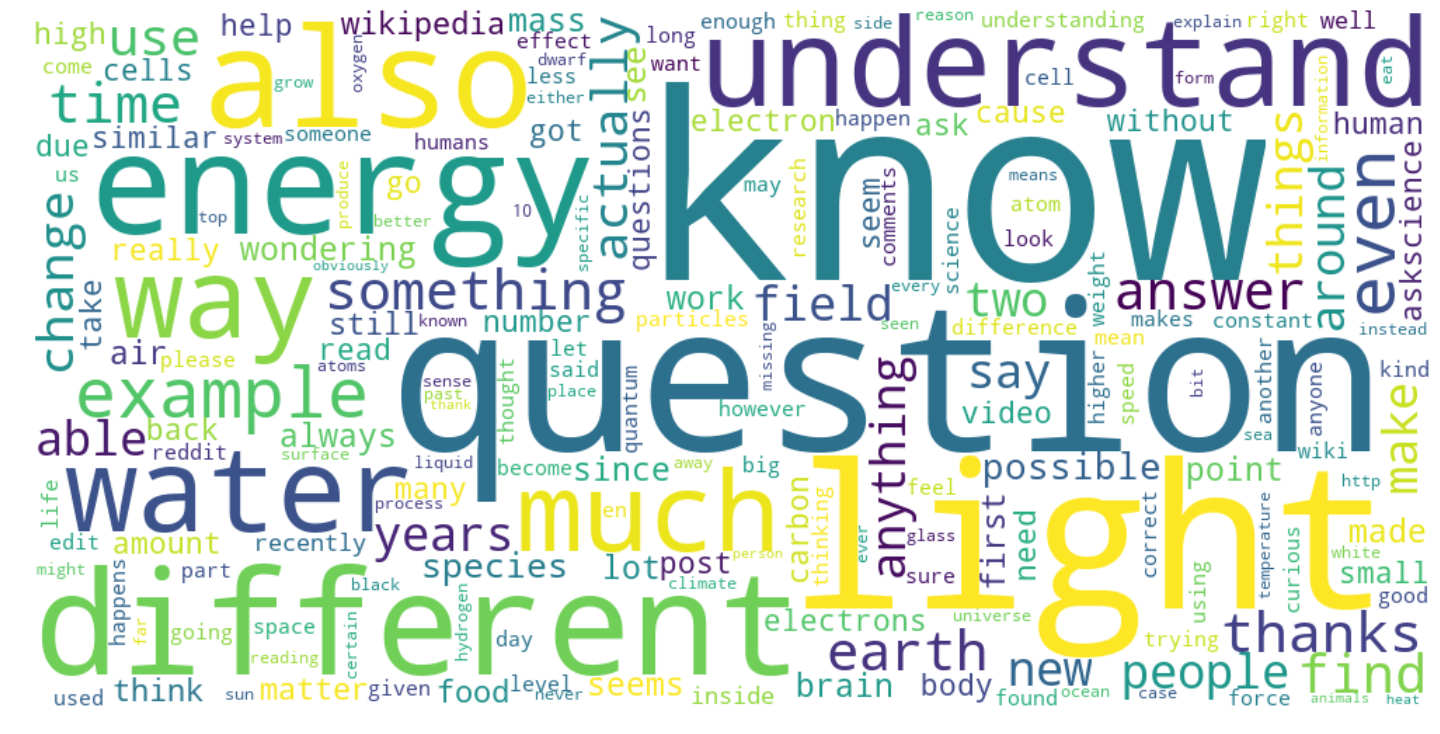

In [105]:
mask = (df['science'] == 1)  # select which subreddit to use
name = 'science'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

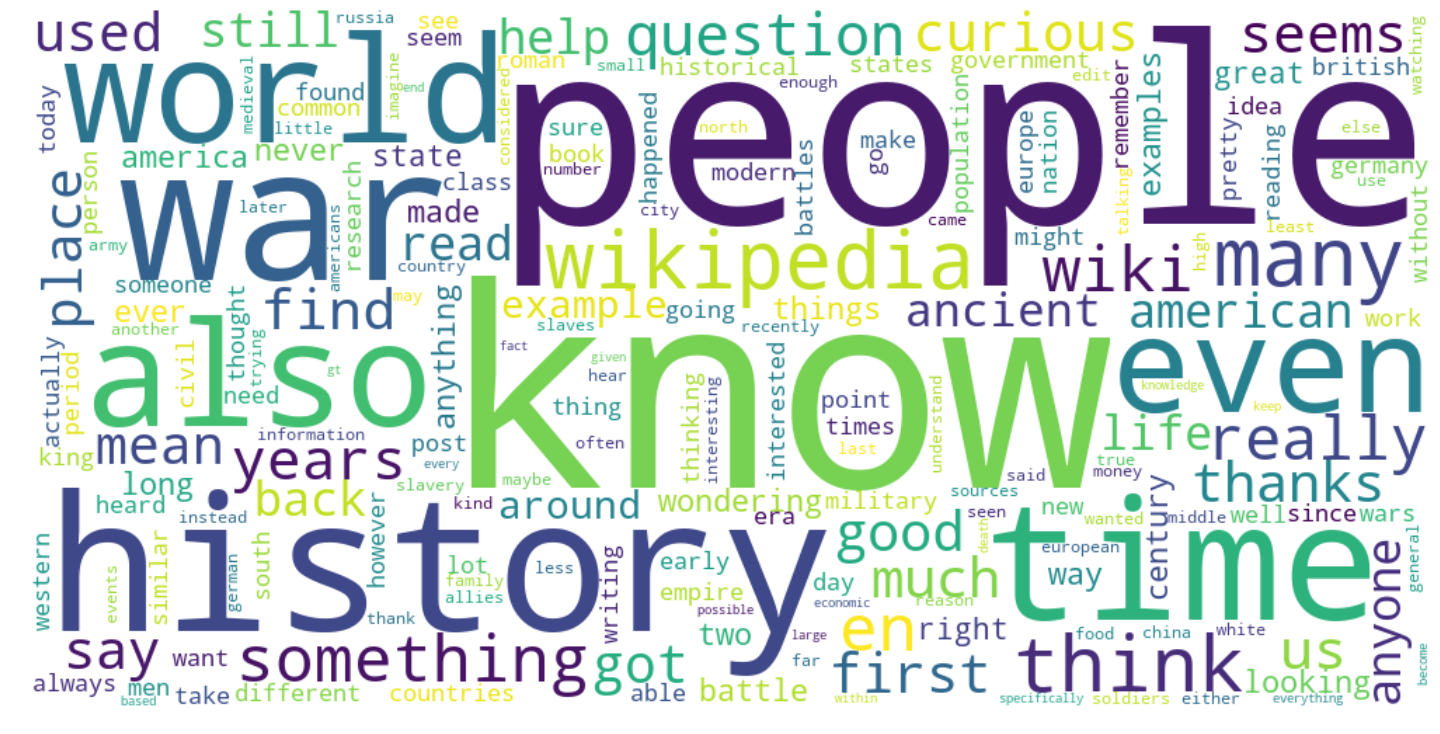

In [106]:
mask = (df['science'] == 0)  # select which subreddit to use
name = 'history'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');